# Part 1: Analysis
This file will try to explore the Amazon Customer Reviews Dataset.

Data source: https://s3.amazonaws.com/amazon-reviews-pds/readme.html

## Dependencies

In [1]:
# Basic packages
import pandas as pd
import numpy as np
import os
import datetime
from tqdm import tqdm as progress_bar

In [2]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

In [3]:
np.seterr(divide = 'ignore') 

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Helper Functions

In [4]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

## Load Data

In [5]:
filepath = os.path.join('data', 'amazon_reviews_us_Electronics_v1_00.tsv')
raw_data = pd.read_csv(filepath, delimiter='\t', on_bad_lines='skip')

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3091024 entries, 0 to 3091023
Data columns (total 15 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   marketplace        object
 1   customer_id        int64 
 2   review_id          object
 3   product_id         object
 4   product_parent     int64 
 5   product_title      object
 6   product_category   object
 7   star_rating        int64 
 8   helpful_votes      int64 
 9   total_votes        int64 
 10  vine               object
 11  verified_purchase  object
 12  review_headline    object
 13  review_body        object
 14  review_date        object
dtypes: int64(5), object(10)
memory usage: 353.7+ MB


In [7]:
raw_data.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31
1,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
2,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31
3,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31
4,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31


This is a dataset with 3091024 observations with the following columns:

DATA COLUMNS:
- marketplace:        2 letter country code of the marketplace where the review was written.
- customer_id:        Random identifier that can be used to aggregate reviews written by a single author.
- review_id:          The unique ID of the review.
- product_id:         The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same product_id.
- product_parent:     Random identifier that can be used to aggregate reviews for the same product.
- product_title:      Title of the product.
- product_category:   Broad product category that can be used to group reviews (also used to group the dataset into coherent parts).
- star_rating:        The 1-5 star rating of the review.
- helpful_votes:      Number of helpful votes.
- total_votes:        Number of total votes the review received.
- vine:               Review was written as part of the Vine program.
- verified_purchase:  The review is on a verified purchase.
- review_headline:    The title of the review.
- review_body:        The review text.
- review_date:        The date the review was written.

## Data Cleaning

### Missing Values

In [8]:
for col in raw_data:
    missing_count = len(raw_data) - raw_data[col].count()
    print(f"missing values in column {col}: {missing_count}")

missing values in column marketplace: 0
missing values in column customer_id: 0
missing values in column review_id: 0
missing values in column product_id: 0
missing values in column product_parent: 0
missing values in column product_title: 4
missing values in column product_category: 0
missing values in column star_rating: 0
missing values in column helpful_votes: 0
missing values in column total_votes: 0
missing values in column vine: 0
missing values in column verified_purchase: 0
missing values in column review_headline: 31
missing values in column review_body: 88
missing values in column review_date: 24


Since there are very few missing values in the dataset, we directly delete those observations.

In [9]:
data = raw_data.dropna()
del raw_data # release memory

### Duplicate Values

In [10]:
data = data.drop_duplicates()

### Irrelevant Data
Drop marketplace since this is a dataset of only US data, similar reason for product_category.

Other dropping column is irrelevant to our analysis.

In [11]:
irrelevant_columns = ['marketplace', 'product_parent', 'product_category']
data.drop(irrelevant_columns, axis='columns', inplace=True)

### Data Types

In [12]:
data['review_date'] = data['review_date'].astype('datetime64[ns]')

## Univariate Analysis

In [13]:
data.head()

,customer_id,review_id,product_id,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,41409413,R2MTG1GCZLR2DK,B00428R89M,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,5,0,0,N,Y,Five Stars,As described.,2015-08-31
1,49668221,R2HBOEM8LE9928,B000068O48,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
2,12338275,R1P4RW1R9FDPEE,B000GGKOG8,Channel Master Titan 2 Antenna Preamplifier,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31
3,38487968,R1EBPM82ENI67M,B000NU4OTA,LIMTECH Wall charger + USB Hotsync & Charging ...,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31
4,23732619,R372S58V6D11AT,B00JOQIO6S,Skullcandy Air Raid Portable Bluetooth Speaker,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31


In [14]:
data.describe()[['star_rating', 'helpful_votes', 'total_votes']] # choose the useful columns

,star_rating,helpful_votes,total_votes
count,3.090877e+06,3.090877e+06,3.090877e+06
mean,4.035425e+00,1.860723e+00,2.372270e+00
std,1.387452e+00,2.133747e+01,2.249734e+01
min,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,0.000000e+00,0.000000e+00
50%,5.000000e+00,0.000000e+00,0.000000e+00
75%,5.000000e+00,1.000000e+00,1.000000e+00
max,5.000000e+00,1.278600e+04,1.294400e+04


### Star Rating

In [15]:
star_ratings = data['star_rating'].value_counts()
star_ratings

5    1779292
4     536394
1     357792
3     238376
2     179023
Name: star_rating, dtype: int64

<AxesSubplot:xlabel='star_rating', ylabel='Count'>

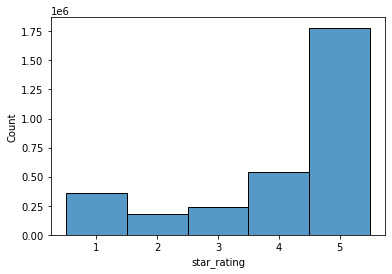

In [16]:
sns.histplot(data=data, x='star_rating', bins=5, discrete=True)

### Helpful Votes

In [17]:
data['helpful_votes'].value_counts()

0       2088815
1        469884
2        172954
3         91595
4         55864
         ...   
1817          1
487           1
4420          1
419           1
590           1
Name: helpful_votes, Length: 895, dtype: int64

<AxesSubplot:xlabel='helpful_votes', ylabel='Count'>

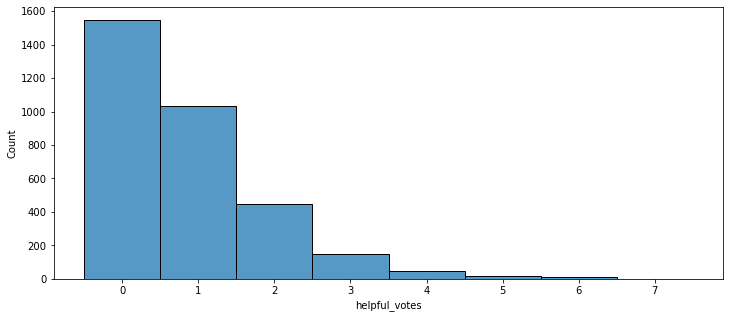

In [18]:
plt.figure(figsize=(12, 5))
sns.histplot(data=np.log(data.sample(10000)['helpful_votes']), discrete=True)

### Total Votes

In [19]:
data['total_votes'].value_counts()

0       1877025
1        510657
2        219216
3        117367
4         75456
         ...   
543           1
888           1
612           1
2371          1
605           1
Name: total_votes, Length: 934, dtype: int64

<AxesSubplot:xlabel='total_votes', ylabel='Count'>

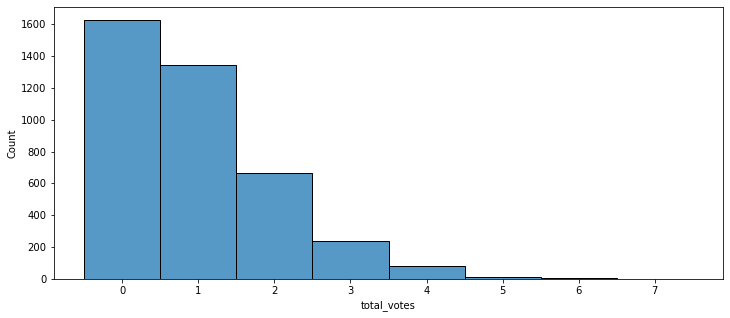

In [20]:
plt.figure(figsize=(12, 5))
sns.histplot(data=np.log(data.sample(10000)['total_votes']), discrete=True)

### Review Dates

In [21]:
data['review_date']

0         2015-08-31
1         2015-08-31
2         2015-08-31
3         2015-08-31
4         2015-08-31
             ...    
3091019   1999-06-14
3091020   1999-06-13
3091021   1999-06-12
3091022   1999-06-12
3091023   1999-06-09
Name: review_date, Length: 3090877, dtype: datetime64[ns]

In [22]:
max(data['review_date'])

Timestamp('2015-08-31 00:00:00')

In [23]:
min(data['review_date'])

Timestamp('1999-06-09 00:00:00')

Overall review frequency trend.

In [24]:
date_value = data.groupby('review_date')['review_id'].count()

<AxesSubplot:xlabel='review_date', ylabel='review_id'>

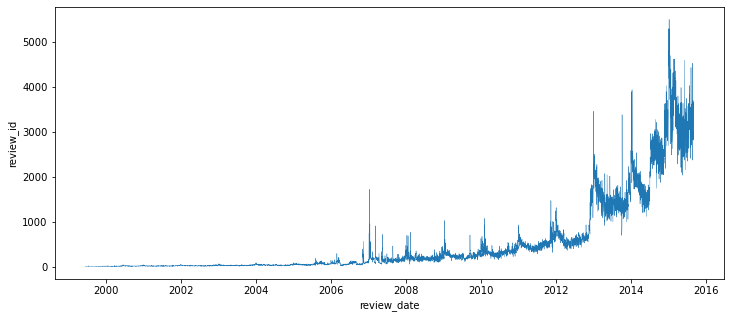

In [25]:
plt.figure(figsize=(12, 5))
sns.lineplot(data = date_value, lw=0.4)

### Periodic Analysis

Split year, month, day, weekdays from datetime

In [26]:
data['review_year'], data['review_month'], data['review_day'] = \
    data['review_date'].astype('string').str.split('-').str[0], data['review_date'].astype('string').str.split('-').str[1], \
    data['review_date'].astype('string').str.split('-').str[2]

In [27]:
data['review_month'], data['review_day'] = \
    data['review_month'].astype(int), data['review_day'].astype(int)

In [28]:
data['review_weekdays'] = data['review_date'].dt.day_name()

Year Analysis

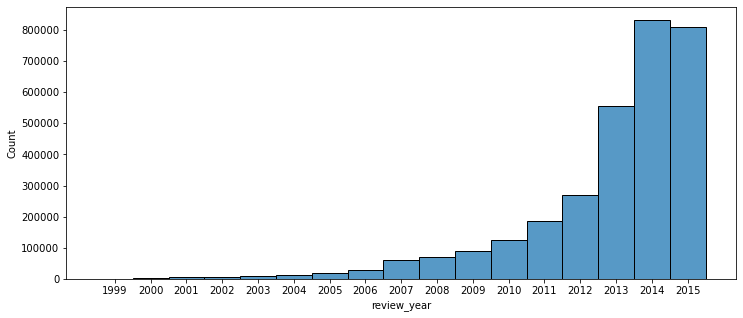

In [29]:
plt.figure(figsize=(12, 5))
sns.histplot(data = data, x='review_year', discrete=True).invert_xaxis()

Month Analysis

<AxesSubplot:xlabel='review_month', ylabel='Count'>

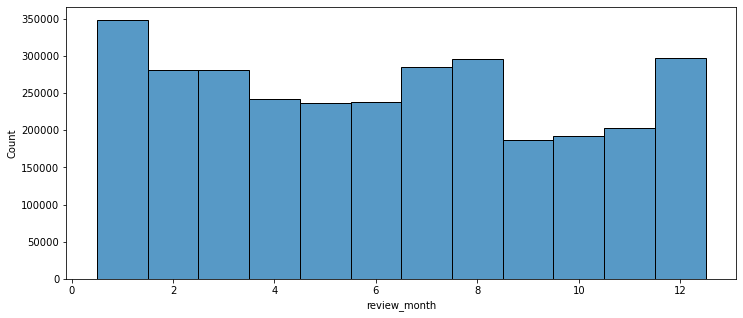

In [30]:
plt.figure(figsize=(12, 5))
sns.histplot(data = data, x='review_month', discrete=True)

Day Analysis

<AxesSubplot:xlabel='review_day', ylabel='Count'>

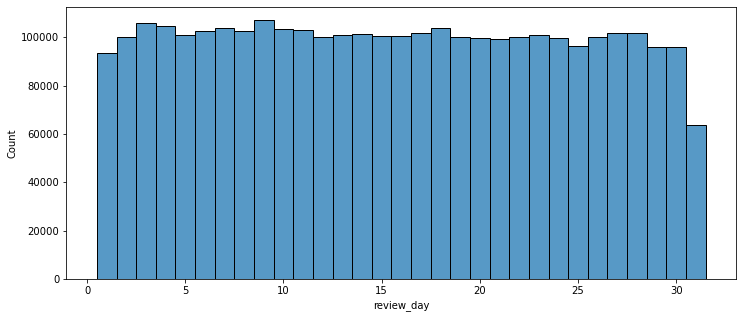

In [31]:
plt.figure(figsize=(12, 5))
sns.histplot(data = data, x='review_day', discrete=True)

Weekdays Analysis

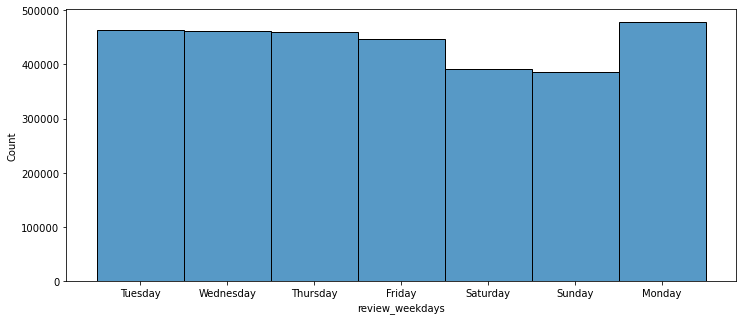

In [32]:
plt.figure(figsize=(12, 5))
sns.histplot(data = data, x='review_weekdays').invert_xaxis()

In [33]:
data.head()

,customer_id,review_id,product_id,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_year,review_month,review_day,review_weekdays
0,41409413,R2MTG1GCZLR2DK,B00428R89M,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,5,0,0,N,Y,Five Stars,As described.,2015-08-31,2015,8,31,Monday
1,49668221,R2HBOEM8LE9928,B000068O48,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31,2015,8,31,Monday
2,12338275,R1P4RW1R9FDPEE,B000GGKOG8,Channel Master Titan 2 Antenna Preamplifier,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31,2015,8,31,Monday
3,38487968,R1EBPM82ENI67M,B000NU4OTA,LIMTECH Wall charger + USB Hotsync & Charging ...,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31,2015,8,31,Monday
4,23732619,R372S58V6D11AT,B00JOQIO6S,Skullcandy Air Raid Portable Bluetooth Speaker,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31,2015,8,31,Monday


### review_body

Frequency histogram

In [34]:
# sample some review body data to make
data['review_len'] = np.log(data['review_body'].str.len())

<AxesSubplot:xlabel='review_len', ylabel='Count'>

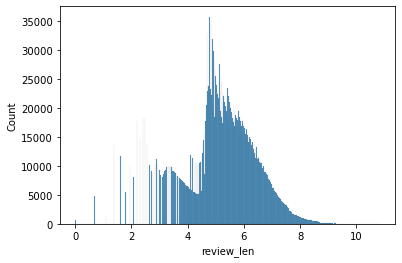

In [35]:
# log length of the review_body
sns.histplot(data = data, x='review_len')

Wordcloud

In [36]:
# decrease size
sample_data = data.sample(30000)

In [37]:
comment_words = ''
stopwords = set(STOPWORDS)

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [00:32<00:00, 910.82it/s]


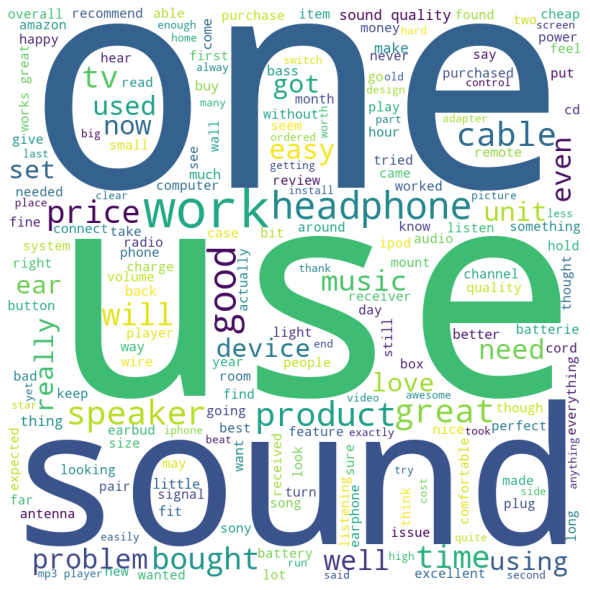

In [38]:
for review in progress_bar(sample_data['review_body']):
    review = str(review) 
    review = review.replace('<br', '')
    tokens = review.split() # split
    # lower character
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens) + " "
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Multivariate Analysis
### Star Rating vs. Product Title
Consider other ML/Model methods rather than manual categories.

In [39]:
# explore the words appeared in the product title
all_words = ' '.join(data['product_title'].to_numpy())
words = pd.DataFrame(all_words.split())
counts = words.value_counts()
counts[:50].index.to_list()

[('with',),
 ('-',),
 ('for',),
 ('and',),
 ('Cable',),
 ('HDMI',),
 ('to',),
 ('Headphones',),
 ('Audio',),
 ('Speaker',),
 ('Bluetooth',),
 ('Wireless',),
 ('by',),
 ('Stereo',),
 ('TV',),
 ('/',),
 ('(Discontinued',),
 ('Manufacturer)',),
 ('Portable',),
 ('Sony',),
 ('Player',),
 ('Adapter',),
 ('Black',),
 ('&',),
 ('Digital',),
 ('Wall',),
 ('High',),
 ('Radio',),
 ('Power',),
 ('Headphone',),
 ('Mount',),
 ('MP3',),
 ('Remote',),
 ('iPod',),
 ('System',),
 ('Battery',),
 ('(Black)',),
 ('2',),
 ('Male',),
 ('3.5mm',),
 ('In-Ear',),
 ('USB',),
 ('Mini',),
 ('RCA',),
 ('GB',),
 ('Apple',),
 ('3D',),
 ('Rechargeable',),
 ('Video',),
 ('Control',)]

In [40]:
# Try to categorize the products

In [41]:
def catelogs(string):
    lower = string.lower()
    
    catelogs = ['phone', 'headphones', 'sound', 'television', 'cable', 'speaker', 'monitor', 'car', 'battery', 'laptop', 'pad',\
               'watch', 'chip', 'pc', 'computer', 'adaptor', 'player', 'charge', 'connector', 'kitchen', 'storage', 'tablet',\
               'tv', 'dvd', 'memory', 'gpu'] # some common electronic devices
    
    for catelog in catelogs:
        if catelog in lower:
            return catelog
    return 'other'

In [42]:
data['category'] = data['product_title'].apply(catelogs)
by_category = data.groupby('category')['star_rating'].mean()
by_category

category
adaptor       3.947763
battery       4.119803
cable         4.272035
car           3.857226
charge        4.193303
chip          4.381227
computer      4.215166
connector     4.273801
dvd           4.047720
gpu           3.739130
kitchen       4.233689
laptop        3.825151
memory        4.216680
monitor       4.236941
other         4.012421
pad           3.974987
pc            3.922399
phone         3.945106
player        3.588514
sound         4.139926
speaker       4.165873
storage       4.227013
tablet        3.828283
television    4.000101
tv            4.011025
watch         3.928418
Name: star_rating, dtype: float64

<AxesSubplot:xlabel='star_rating', ylabel='category'>

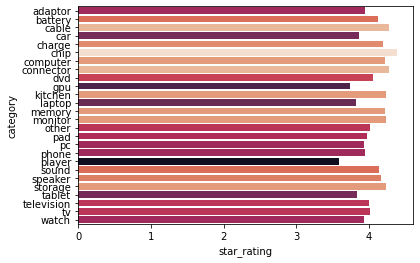

In [43]:
sns.barplot(data = pd.DataFrame(by_category).reset_index(), y='category', x='star_rating', orient='h', \
            palette=colors_from_values(by_category, "rocket"))

In [44]:
def brandize(string):
    lower = string.lower()
    
    catelogs = ['samsung', 'apple', 'sony', 'nvidia', 'amd', 'cisco', 'nintendo', 'xiaomi', 'dell',\
               'hp', 'canon', 'mitsubishi', 'lg', 'lenovo', 'nikon', 'intel', 'asus', 'gigabyte',\
               'seagate', 'kingston', 'casio'] # some common electronic brands
    
    for catelog in catelogs:
        if catelog in lower:
            return catelog
    return 'other'

In [45]:
data['brand'] = data['product_title'].apply(brandize)
by_brand = data.groupby('brand')['star_rating'].mean()
by_brand

brand
amd           4.027491
apple         3.987114
asus          3.792748
canon         3.996056
casio         3.724638
cisco         4.063075
dell          3.710526
gigabyte      3.967033
hp            3.860215
intel         4.186854
kingston      4.542510
lenovo        3.244862
lg            4.163451
mitsubishi    3.665214
nikon         4.121867
nintendo      3.667043
nvidia        3.964286
other         4.042058
samsung       3.992555
seagate       4.103896
sony          4.044151
xiaomi        4.022556
Name: star_rating, dtype: float64

<AxesSubplot:xlabel='star_rating', ylabel='brand'>

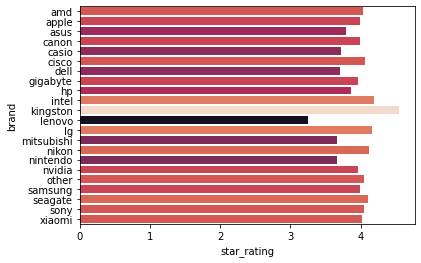

In [46]:
sns.barplot(data = pd.DataFrame(by_brand).reset_index(), y='brand', x='star_rating', orient='h', \
            palette=colors_from_values(by_brand, "rocket"))

### Review Weekdays vs. Star Rating

<AxesSubplot:xlabel='star_rating', ylabel='Count'>

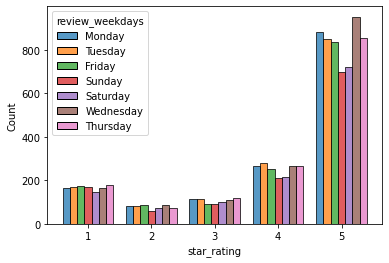

In [47]:
sns.histplot(data = data.sample(10000), x='star_rating', hue='review_weekdays',multiple="dodge", discrete=True, shrink=0.8)

In [48]:
data.head()

,customer_id,review_id,product_id,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_year,review_month,review_day,review_weekdays,review_len,category,brand
0,41409413,R2MTG1GCZLR2DK,B00428R89M,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,5,0,0,N,Y,Five Stars,As described.,2015-08-31,2015,8,31,Monday,2.564949,cable,other
1,49668221,R2HBOEM8LE9928,B000068O48,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31,2015,8,31,Monday,3.178054,adaptor,other
2,12338275,R1P4RW1R9FDPEE,B000GGKOG8,Channel Master Titan 2 Antenna Preamplifier,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31,2015,8,31,Monday,2.397895,other,other
3,38487968,R1EBPM82ENI67M,B000NU4OTA,LIMTECH Wall charger + USB Hotsync & Charging ...,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31,2015,8,31,Monday,2.995732,player,apple
4,23732619,R372S58V6D11AT,B00JOQIO6S,Skullcandy Air Raid Portable Bluetooth Speaker,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31,2015,8,31,Monday,4.418841,speaker,other


### Verified Purchase vs. Star Rating

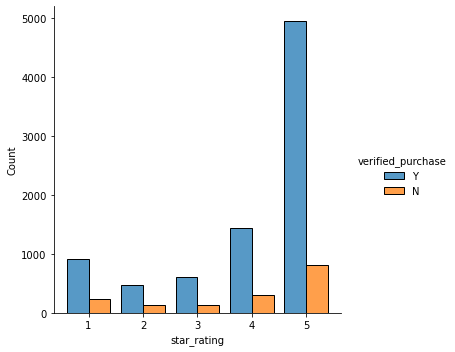

In [49]:
sns.displot(data = data.sample(10000), x='star_rating', hue='verified_purchase', multiple="dodge", discrete=True, shrink=0.8)

### Review Length vs. Star Rating

<AxesSubplot:xlabel='star_rating', ylabel='review_len'>

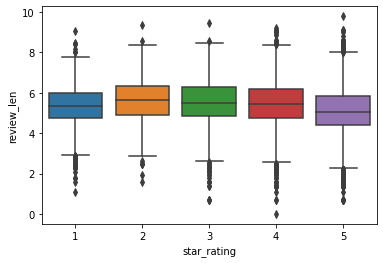

In [50]:
sns.boxplot(data = data.sample(10000), y='review_len', x = 'star_rating')